In [1]:
from operator import add, truediv
from collections import Counter
from numba import njit,vectorize, prange, errors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from matplotlib import animation, rc
from IPython.display import HTML

In [3]:
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import numpy as np
import itertools
import warnings
import random
import sys
import os

In [4]:
warnings.simplefilter('ignore', category=errors.NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=errors.NumbaPendingDeprecationWarning)

In [5]:
sbn.set()

# 1. Procesos en membranas (mallas). 

En un notebook pasado ya aboradamos el algortimo de Gillespie con poblaciones abiertas y cerradas pero la geometría del problema no era explícita. En esta vez vamos a inducir una geometría discreta muy similar a _parches_ donde éstos van a tener poblaciones de especies químicas que se relacionarán y podrán interactuar no solamente de manera local sino también de manera global. 

## 1.1 Una reacción sencilla

Vamos a comenzar con un proiceso en una malla simétrica con condiciones periódicas a la frontera. Va a analizar primero a siguiente reacción
$$
S_{i} \xrightarrow{\;\; c \;\; } \emptyset
$$
Donde $S_{i}$ es la población de especie $S$ en el nodo $i$. Para esta primera parte vamos a asumir que no hay un proceso de difusión (los nodos están aislados).

Vamos a comenzar una malla de $3\times 3$, inicializaremos un número entero aleatorio para cada punto de la malla.

In [6]:
M = np.random.randint(low=0,high = 1000,size=(3,3))

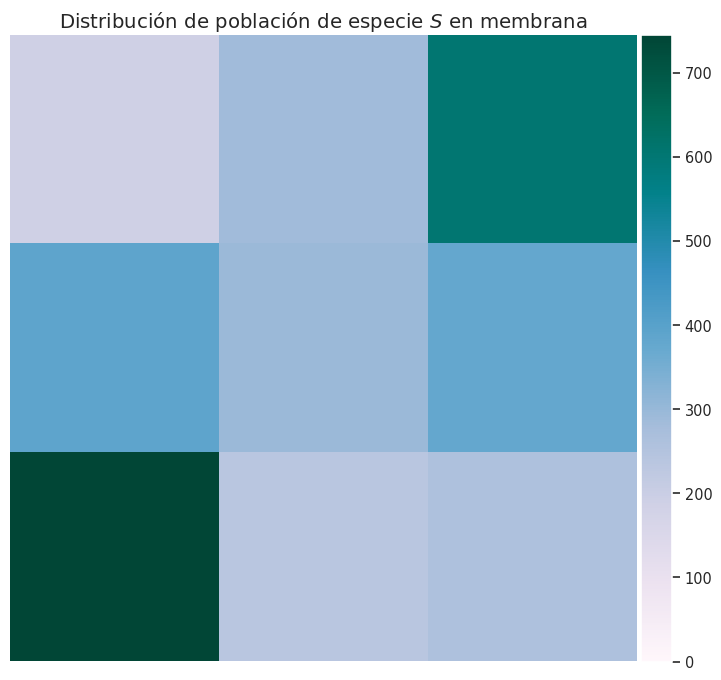

In [7]:
fig,ax = plt.subplots(1,1,dpi=95,figsize=(9,9))

im = ax.imshow(M,
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax.set_title(r'Distribución de población de especie $S$ en membrana',
             fontdict={'fontsize':15,})
ax.set_axis_off()

plt.show()

Ahora, vamos a realizar la simulación para la evolución de la población global en la membrana en función de cada uno de los patches siguiento el algoritmo de Gillespie. 
Como solamente tenemos una función el vector de cambio será $\nu = -1$ y la probabilidad de una reacción a ocurrir en cada uno de los pathches será proporcional a la abundacia molecular de especies en ese parche.

In [8]:
@njit
def random_exp_numpy(a0):
    """
    This functions generates a exponential random 
    variable with mean and std. dev. 1/a0
    """
    r = np.random.random()
    return (1/a0)*np.log(1/r)

@njit
def sum_vectors_list(a,b):
    l = []
    n = len(a)
    for i in prange(n):
        l.append(a[i]+b[i])
    return l

@njit
def sum_vect(a):
    n = len(a)
    k = 0.0
    for i in prange(n):
        k += a[i]
    return k

@njit
def div_vect(a,a0):
    n = len(a)
    b = []
    for i in prange(n):
        b.append(a[i]/a0)
    return b

In [9]:
_=random_exp_numpy(2)
_=sum_vectors_list([1,2],[1,2])
_=sum_vect([1,2])
_=div_vect([1,2],1)

In [11]:
def SSA(M,t_max=1):
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    
    sp = M.shape[0] #define dimension
    n = sp**2
    patch_idx_2d = list(itertools.product(range(sp),range(sp)))
    patch_idx = list(range(sp**2))
    while t0<=t_max:
        
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        
        #selct patch
        m_sum = np.sum(Mt)
        j = random.choices(patch_idx, weights=map(truediv,M.reshape(M.shape[0]**2),[m_sum]*n))[0]
        #print(j)
        #print(patch_idx_2d[j])
        #break
        Mt[patch_idx_2d[j][0],patch_idx_2d[j][1]] += -1
        tau = random_exp_numpy(m_sum)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [12]:
evolM,T = SSA(M,t_max=5)

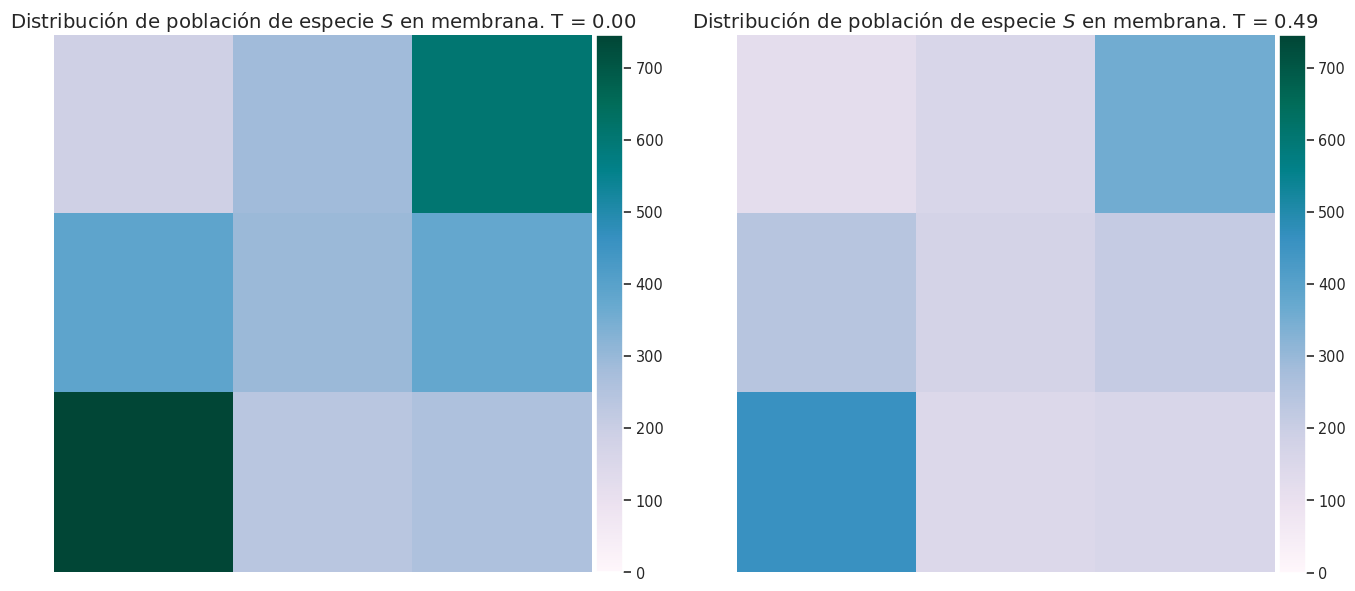

In [13]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

im = ax[0].imshow(M,
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[0]),
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(evolM[-2000],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[-2000]),
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

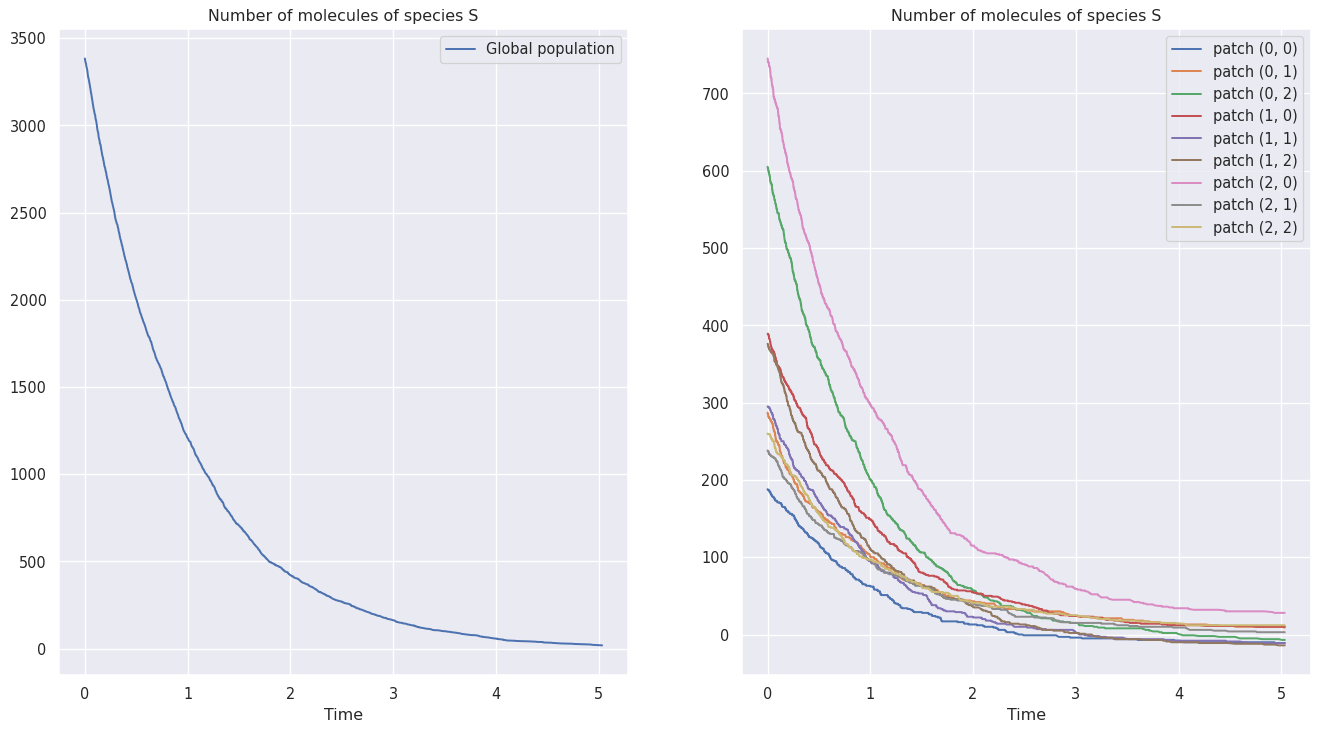

In [14]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

ax[0].plot(T,[np.sum(m) for m in evolM],label='Global population')
ax[0].set_title('Evolución de la población global de la espcie S',)
ax[0].set_xlabel('Time')
ax[0].set_title('Number of molecules of species S')
ax[0].legend()

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[1].plot(T,[m[patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch))

ax[1].set_xlabel('Time')
ax[1].set_title('Number of molecules of species S')
ax[1].legend()

plt.show()

Una cosa bien importante de notar que es podemos ver que en algunas partes la población de moleculas se hace cero mismo que no tiene sentido. Por ello vamos a poner una constricción del tipo $a_{+}$ donde $a_{+} = a \; if\; a\ge0 \;otherwise\; 0 $

In [15]:
@njit
def a_positive(a):
    if a>=0:
        return a
    else:
        return 0

In [16]:
_ = a_positive(3)

In [17]:
def SSA(M,t_max=1):
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    
    sp = M.shape[0] #define dimension
    n = sp**2
    patch_idx_2d = list(itertools.product(range(sp),range(sp)))
    patch_idx = list(range(sp**2))
    while t0<=t_max:
        
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        
        #selct patch
        m_sum = np.sum(Mt)
        j = random.choices(patch_idx, weights=map(truediv,M.reshape(M.shape[0]**2),[m_sum]*n))[0]
        #print(j)
        #print(patch_idx_2d[j])
        #break
        Mt[patch_idx_2d[j][0],patch_idx_2d[j][1]] = a_positive(Mt[patch_idx_2d[j][0],patch_idx_2d[j][1]]-1)
        tau = random_exp_numpy(m_sum)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [18]:
evolM,T = SSA(M,t_max=5)

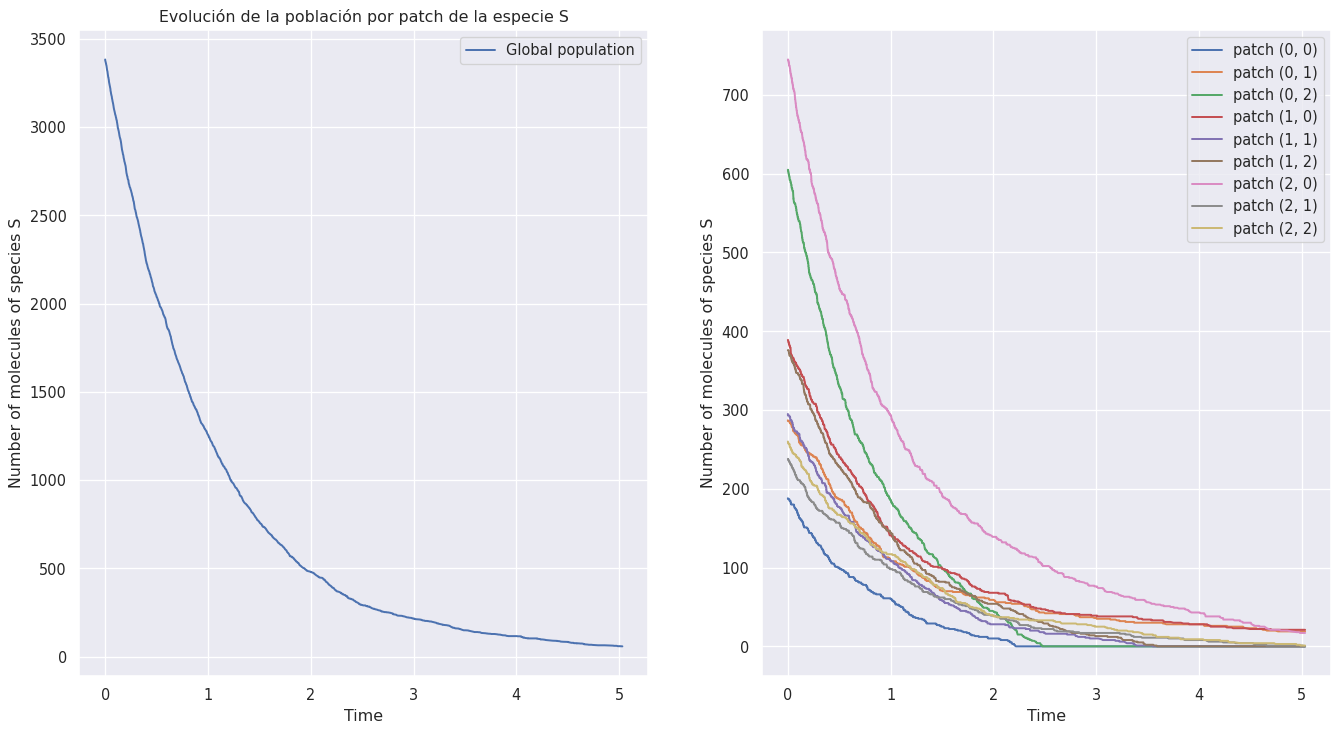

In [19]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

ax[0].plot(T,[np.sum(m) for m in evolM],label='Global population')
ax[0].set_title('Evolución de la población global de la espcie S',)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of molecules of species S')
ax[0].legend()

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[1].plot(T,[m[patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch))

ax[0].set_title('Evolución de la población por patch de la especie S',)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Number of molecules of species S')
ax[1].legend()

plt.show()

## 1.2 Introducción de difusión

Ahora que el problema está corregido vamos a comenzar a agregar la difusión, esto es considerar el set de reacciones:
$$
\begin{eqnarray}
S_{i} \xrightarrow{\;\; c_{1} \;\; } \emptyset \\
S_{i} \xrightarrow{\;\; c_{2} \;\; } S_{j}
\end{eqnarray}
$$

Aquí o bien se mueve una molécula del patch $i$ al $j$ (proceso difusivo) o bien se convierte decae a la especie $\emptyset$

In [20]:
def reactions(Y,c1=1,c2=0.4):
    return [Y*c1,Y*c2]

In [21]:
def SSA_diff(M,a,v,t_max=1,seed=42):
    
    np.random.seed(seed=42)
    
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    
    sp = M.shape[0] #define dimension
    n = sp**2 # Define flaten dimension
    patch_idx_2d = list(itertools.product(range(sp),range(sp))) #define all the combinations of matrix entries
    patch_idx = list(range(sp**2)) #The idx of patch_idx_2d combinations
    neighb_patch = list(filter(lambda x: abs(x[0])!=abs(x[1]),itertools.product(range(-1,2),range(-1,2)))) # The valid neighbors
    idx = list(range(len(v)))
    while t0<=t_max:
        
        #select population
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        m_sum = np.sum(Mt)
        
        #select reaction
        a_vector = a(m_sum)
        a_0 = np.sum(a_vector)
        j = random.choices(idx,weights=a_vector/a_0)[0]
        
        
        #selct patch
        J = random.choices(patch_idx, weights=map(truediv,M.reshape(M.shape[0]**2),[m_sum]*n))[0]
        
        if j == 0:
            Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]] = a_positive(Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]]-1)
        else:
            if a_positive(Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]]-1) > 0:
                dummy = random.choices(neighb_patch,k=1)[0]
                Mt[(patch_idx_2d[J][0]+dummy[0])%sp ,(patch_idx_2d[J][1]+dummy[1])%sp ] += 1
                Mt[patch_idx_2d[J][0],patch_idx_2d[J][1]] += -1
                #print('{}->{},{}'.format(patch_idx_2d[J],[(patch_idx_2d[J][0]+dummy[0])%sp ,(patch_idx_2d[J][1]+dummy[1])%sp],dummy))
            
        tau = random_exp_numpy(m_sum)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [22]:
evolM_p,T_p = SSA_diff(M,a=reactions,v=[-1,-1],t_max=5,seed=3)

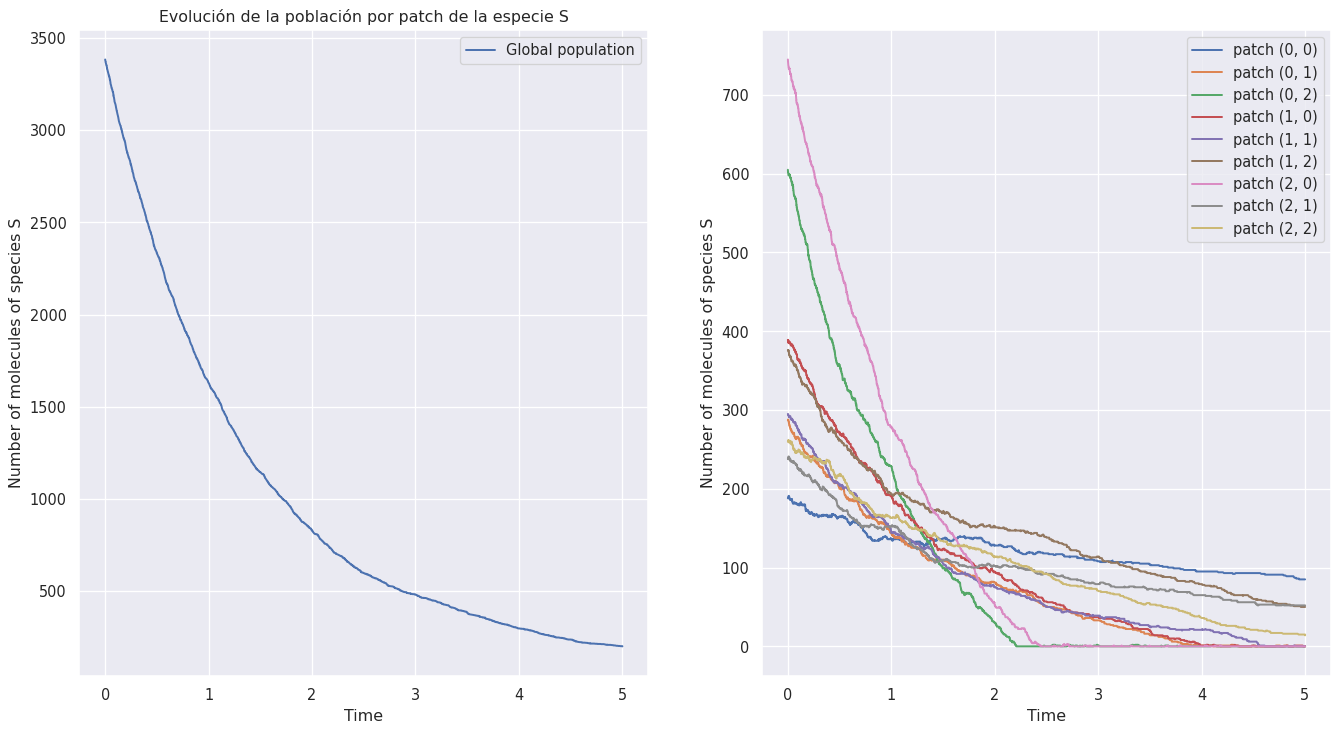

In [23]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

ax[0].plot(T_p,[np.sum(m) for m in evolM_p],label='Global population')
ax[0].set_title('Evolución de la población global de la espcie S',)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Number of molecules of species S')
ax[0].legend()

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[1].plot(T_p,[m[patch[0],patch[1]] for m in evolM_p], label='patch {}'.format(patch))

ax[0].set_title('Evolución de la población por patch de la especie S',)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Number of molecules of species S')
ax[1].legend()

plt.show()

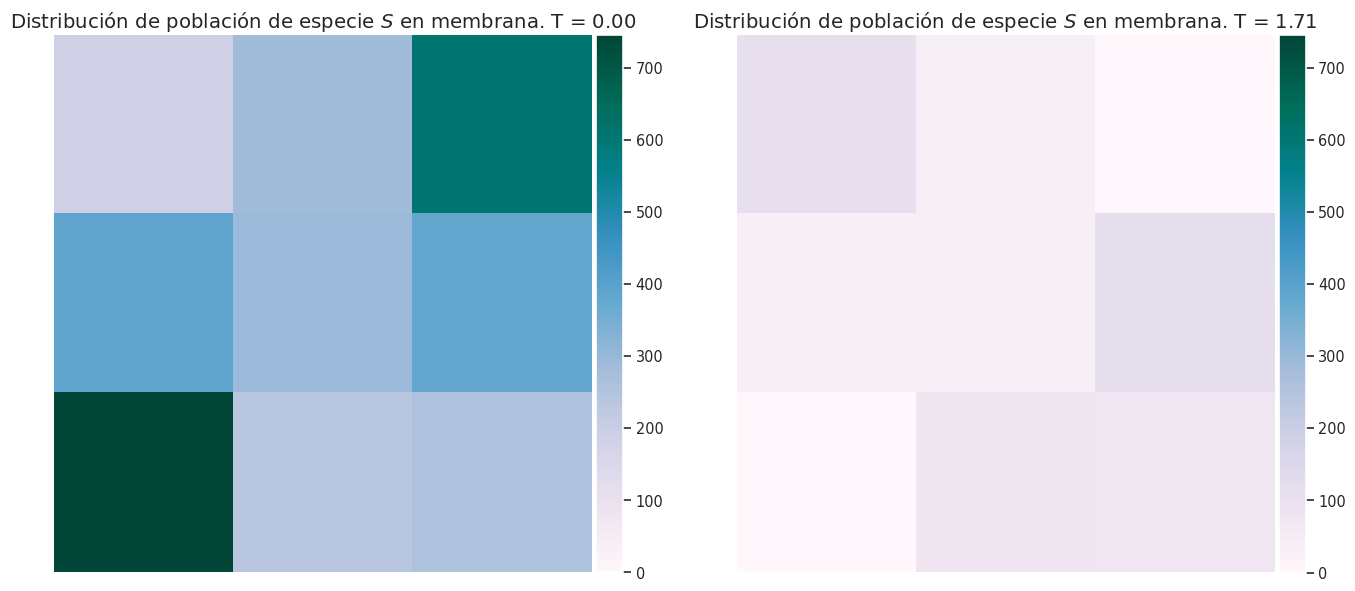

In [24]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

im = ax[0].imshow(M,
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[0]),
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(evolM_p[-700],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $S$ en membrana. T = {:.2f}'.format(T[-700]),
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

Ahora, ya vimos cómo evolucionan las curvas de población, vamos a ver como evoluciona en tiempo la población de la especie en la membrana. El comportamiento lo veremos primero en el caso sin difusión y luego en el caso con difusión. 

In [25]:
fig, ax = plt.subplots(1,1,figsize=(9,8),dpi=93)
img = []
ax.set_axis_off()
im = ax.imshow(evolM[0],cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax.set_title('Decay without diffusion')
for t,m in zip(T[1::30],evolM[1::30]):
    title = ax.text(0.5,1.05,"T = {:.2f}".format(t), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    img.append([ax.imshow(m,
                          cmap='PuBuGn',
                          vmin=0,
                          vmax=np.max(M),),title])
    
plt.close()

In [27]:
anim = animation.ArtistAnimation(fig, img, interval=80, blit=True,repeat_delay=0)
with open("./gifs/decay/decay_without_difussion.html", "w") as f:
    print(anim.to_html5_video(), file=f)

In [28]:
rc('animation', html='jshtml')
HTML(anim.to_jshtml())

El caso anterior fue sin difusión, ahora vamos a ver cómo va con difusión. 

In [29]:
fig, ax = plt.subplots(1,1,figsize=(9,8),dpi=93)
img = []
ax.set_axis_off()
im = ax.imshow(evolM[0],cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
ax.set_title('Decay with diffusion')
for t,m in zip(T_p[1::30],evolM_p[1::30]):
    title = ax.text(0.5,1.05,"T = {:.2f}".format(t), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    img.append([ax.imshow(m,
                          cmap='PuBuGn',
                          vmin=0,
                          vmax=np.max(M),),title])
    
plt.close()

In [30]:
anim = animation.ArtistAnimation(fig, img, interval=80, blit=True,repeat_delay=0)
with open("./gifs/decay/decay_with_difussion.html", "w") as f:
    print(anim.to_html5_video(), file=f)

In [31]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='jshtml')
HTML(anim.to_jshtml())

Para consultar las animacione sin hacer el render se pueden visitar para [decaimiento sin difusión](./gifs/decay/decay_with_difussion.html) y de igual manera el [decaimiento con difusión](./gifs/decay/decay_with_difussion.html)

Así pues, podemos ver como diferencia entre los sistemas que hay un pequeño brote en los parches de las poblaciones. Esto sucede porque la probabilidad de que suceda una reacción en un nodo definido es proporcional a la cantidad de moelculas de la especie $S$ en cada parche; así pues, si hay una cantidad menor en un parche comparado con el resto entonces es más probable que no sucedan decaimientos sino que llegen nuevas moléculas. 

Veamos qué pasa si hacemos más intenso el efecto de la difusión. Hasta ahora el coeficiente de difusión era $c_2 = 0.4$ vamos a hacer pruebas pasando este número a $0.8$, $1.0$ y $1.4$

In [32]:
evolM_p_08,T_p_08 = SSA_diff(M,a=lambda x:reactions(x,c2=0.8),v=[-1,-1],t_max=5)
evolM_p_10,T_p_10 = SSA_diff(M,a=lambda x:reactions(x,c2=1.0),v=[-1,-1],t_max=5)
evolM_p_14,T_p_14 = SSA_diff(M,a=lambda x:reactions(x,c2=1.4),v=[-1,-1],t_max=5)

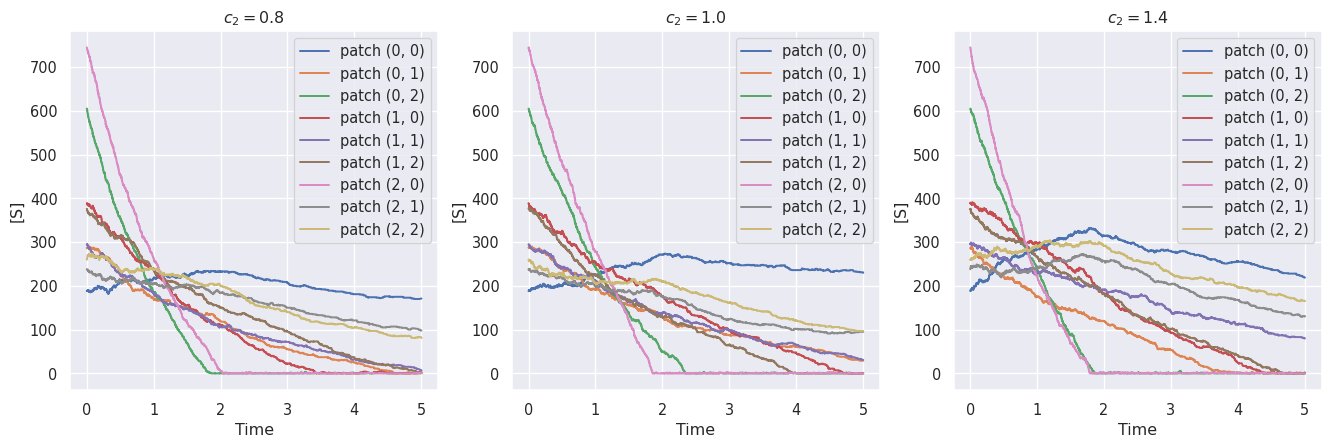

In [33]:
fig,ax = plt.subplots(1,3,dpi=95,figsize=(17,5))

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[0].plot(T_p_08,[m[patch[0],patch[1]] for m in evolM_p_08], label='patch {}'.format(patch))

ax[0].set_title(r'$c_{2}=0.8$',)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('[S]')
ax[0].legend()

for patch in patch_idx_2d:
    ax[1].plot(T_p_10,[m[patch[0],patch[1]] for m in evolM_p_10], label='patch {}'.format(patch))

ax[1].set_title(r'$c_{2}=1.0$',)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('[S]')
ax[1].legend()

for patch in patch_idx_2d:
    ax[2].plot(T_p_14,[m[patch[0],patch[1]] for m in evolM_p_14], label='patch {}'.format(patch))

ax[2].set_title(r'$c_{2}=1.4$',)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('[S]')
ax[2].legend()



plt.show()

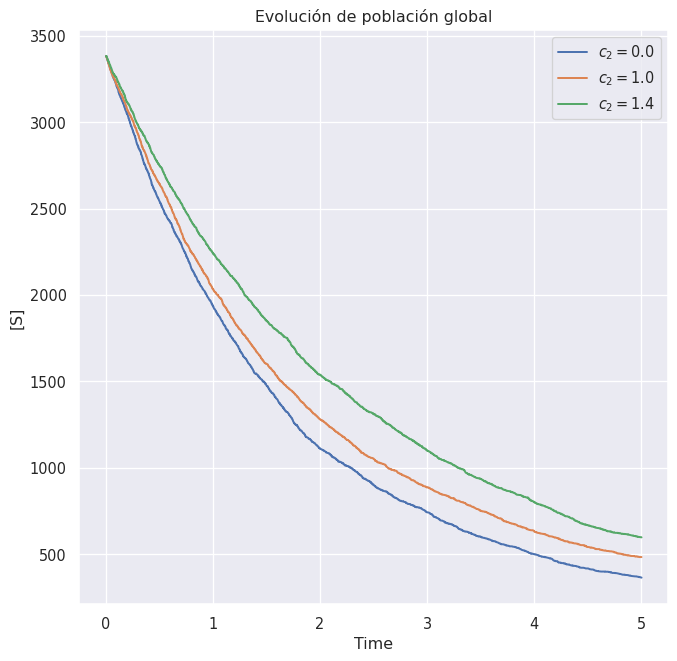

In [34]:
fig,ax = plt.subplots(1,1,dpi=95,figsize=(8,8))

ax.plot(T_p_08,[np.sum(m) for m in evolM_p_08],label=r'$c_{2}=0.0$')

ax.plot(T_p_10,[np.sum(m) for m in evolM_p_10],label=r'$c_{2}=1.0$')

ax.plot(T_p_14,[np.sum(m) for m in evolM_p_14],label=r'$c_{2}=1.4$')

ax.set_title('Evolución de población global')
ax.set_xlabel('Time')
ax.set_ylabel('[S]')
ax.legend()

plt.show()

Notemos que conforme crece el coeficiente de difusión el efecto del decaimiento se mengua.

## 1.3 Un reacción más compleja: Reacciones de Lotka

Las reacciones de Lotka, como vimos en el [notebook pasado](./Epoch_1.ipynb#2.3-The-Lotka-Reactions-(cfr.-[2])), son las siguientes
$$
\begin{eqnarray}
&\bar{X} + Y_{1}& \xrightarrow{\;\; C_{1} \;\; } 2Y_{1} \\
&Y_{1} + Y_{2}& \xrightarrow{\;\; C_{2} \;\; } 2Y_{2} \\
&Y_{2}& \xrightarrow{\;\; C_{3} \;\; } Z
\end{eqnarray}
$$

Donde $\bar{X}$ denota una población molecular constante en el tiempo.

Las ecuaciones de propensidad son las siguientes:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}][Y_{1}] = k[Y_{1}]\\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}]
\end{eqnarray}
$$
Y los vectores de _cambio de estado_ son los siguientes:
$$
\begin{eqnarray}
\nu_{1} &=& [1,0] \\
\nu_{2} &=& [-1,-1] \\
\nu_{3} &=& [0,-1]
\end{eqnarray}
$$

Ahora, tenemos que para reproducir el comportamiento oscilatorio tenemos que usar los coeficientes $k=c_{1}[\bar{X}] = 10$, $c_{2}=0.01$ and $c_{3}=10$ pero vamos a dejar abierta la posibilidad de tener cualquier conjunto de condiciones iniciales en cada parche. 

In [35]:
def R(Y,k=10,c2=0.01,c3=10):
    return np.asarray([k*Y[0],c2*Y[0]*Y[1], c3*Y[1]])

Como en el ejemplo anterior primero consideraremos cada patch de manera aislada, en la membrana no habrá difusión.  

De igual manera, vamos a considerar una en este caso un tensor que guarde todos los estados de la membrana.

In [36]:
M = np.array([np.random.randint(low=0,high = 2000,size=(3,3)),np.random.randint(low=0,high = 1000,size=(3,3))])

In [37]:
M = np.array([np.ones((3,3))*1000,np.ones((3,3))*1000])

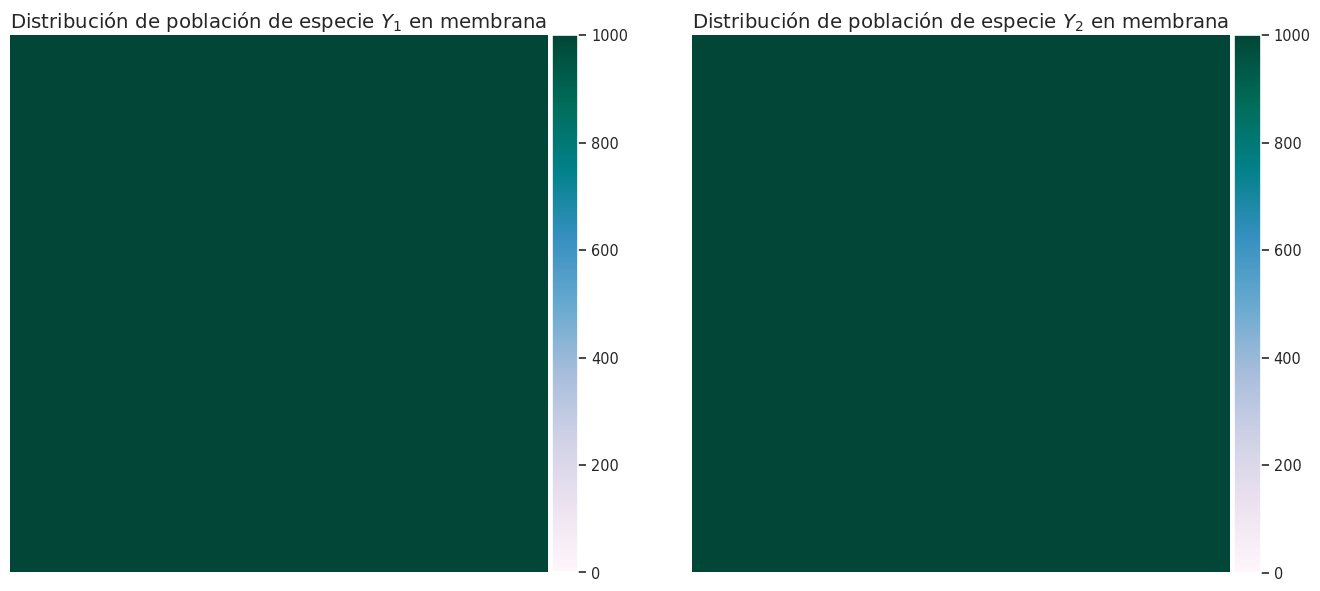

In [38]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

im = ax[0].imshow(M[0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M[0]))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $Y_{1}$ en membrana',
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(M[1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(M[1]))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $Y_{2}$ en membrana',
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

In [39]:
def select_patch(tensor,interest_func_selection,patch_idx,n):
    A = np.sum(tensor[interest_func_selection,:,:],axis=0).reshape(n)
    return random.choices(patch_idx, weights=map(truediv,A,[sum(A)]*n))[0]

In [41]:
def SSA(M,a,interest_func,v,t_max=1,seed=42):
    
    np.random.seed(seed=42)
    
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    #Jj = []
    sp = M.shape[1] #define dimension
    n = sp**2 # Define flaten dimension
    patch_idx_2d = list(itertools.product(range(sp),range(sp))) #define all the combinations of matrix entries
    patch_idx = list(range(sp**2)) #The idx of patch_idx_2d combinations
    neighb_patch = list(filter(lambda x: abs(x[0])!=abs(x[1]),itertools.product(range(-1,2),range(-1,2)))) # The valid neighbors
    idx = list(range(len(v)))
    while t0<=t_max:
        
        #select population
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        m_sum = [np.sum(i) for i in Mt]
        
        #select reaction
        a_vector = a(m_sum)
        a_0 = np.sum(a_vector)
        j = random.choices(idx,weights=a_vector/a_0)[0]
       
        #selct patch
        J = select_patch(M,interest_func[j],patch_idx,n)
        for p in range(Mt.shape[0]):
            Mt[p,patch_idx_2d[J][0],patch_idx_2d[J][1]] = a_positive(Mt[p,patch_idx_2d[J][0],patch_idx_2d[J][1]]+v[j][p])
            
        tau = random_exp_numpy(a_0)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [42]:
interest_func = [[0],
                 [0,1],
                 [1]]

In [43]:
v = [[1,0],
    [-1,1],
    [0,-1]]

In [45]:
evolM, T = SSA(M,a=R,interest_func=interest_func,v=v,t_max=30)

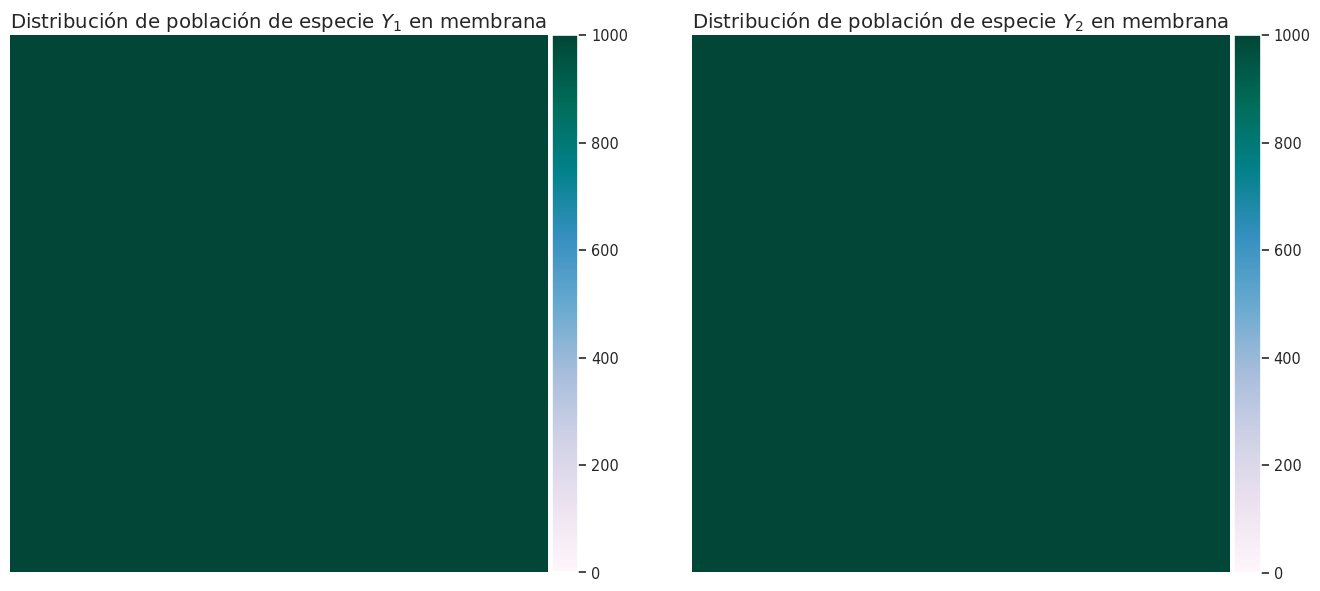

In [46]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

im = ax[0].imshow(evolM[0][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $Y_{1}$ en membrana',
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(evolM[0][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $Y_{2}$ en membrana',
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

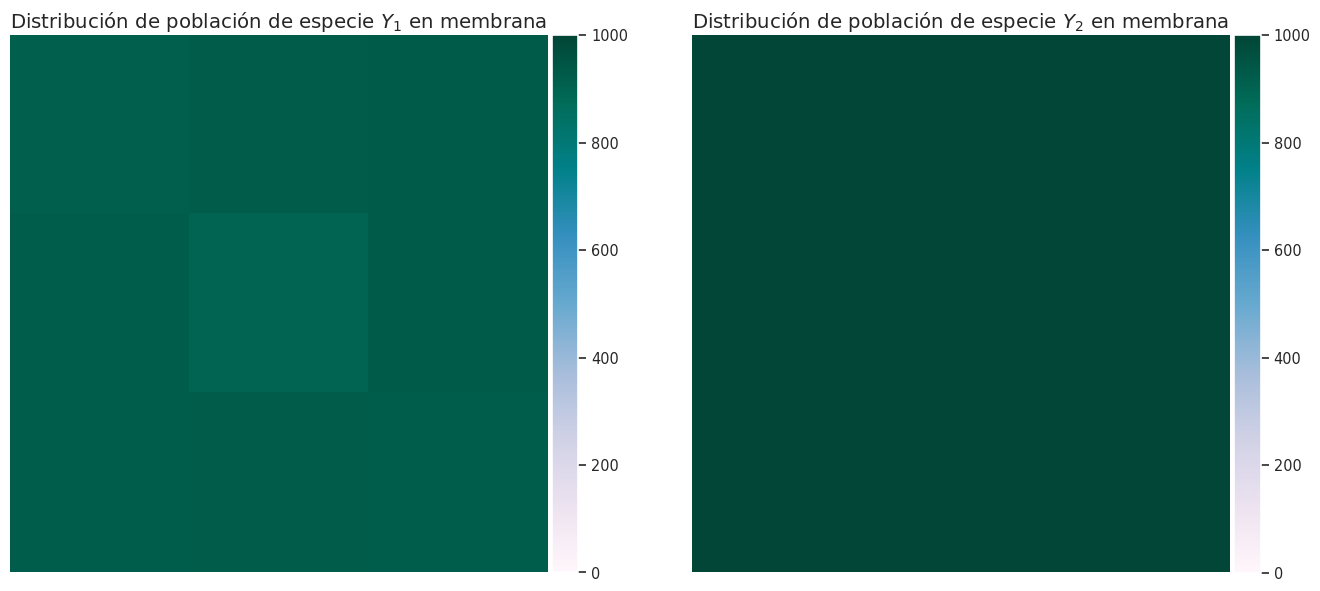

In [47]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,9))

a = 1000

im = ax[0].imshow(evolM[a][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0].set_title(r'Distribución de población de especie $Y_{1}$ en membrana',
             fontdict={'fontsize':15,})
ax[0].set_axis_off()

im = ax[1].imshow(evolM[a][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1].set_title(r'Distribución de población de especie $Y_{2}$ en membrana',
             fontdict={'fontsize':15,})
ax[1].set_axis_off()

plt.show()

In [48]:
Y1,Y2 = zip(*[(np.sum(m[0]),np.sum(m[1])) for m in evolM])

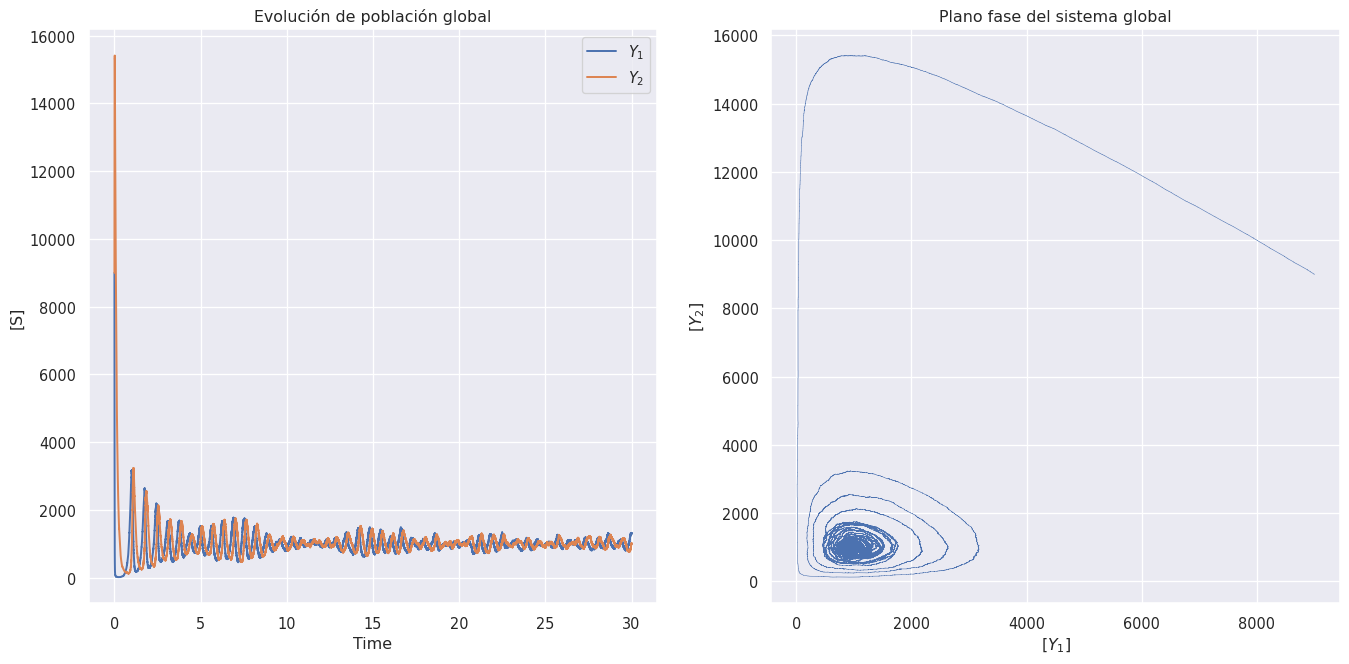

In [54]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,8))

ax[0].plot(T,Y1,label=r'$Y_{1}$')
ax[0].plot(T,Y2,label=r'$Y_{2}$')

ax[0].set_title('Evolución de población global')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('[S]')
ax[0].legend()

ax[1].plot(Y1,Y2,lw=0.4)
ax[1].set_title('Plano fase del sistema global')
ax[1].set_xlabel(r'[$Y_{1}$]')
ax[1].set_ylabel(r'[$Y_{2}$]')
#ax[1].legend()


plt.show()

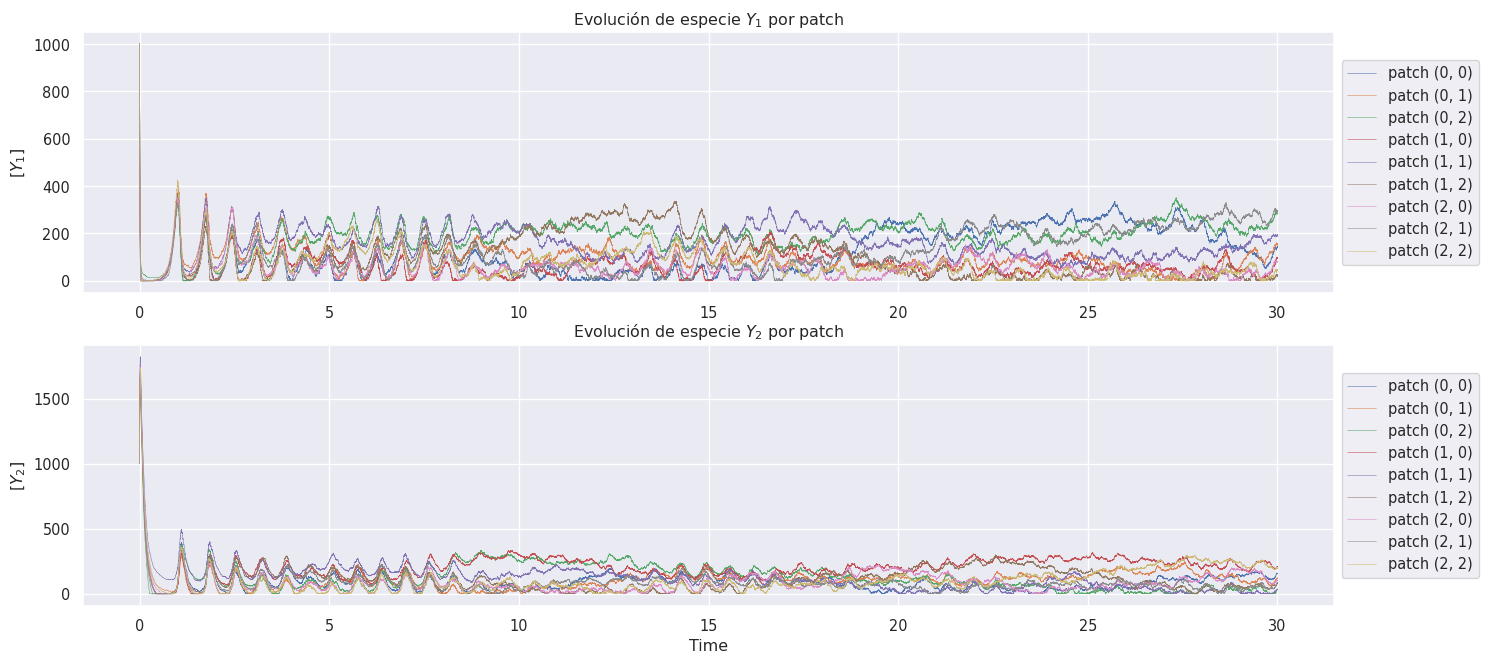

In [89]:
fig,ax = plt.subplots(2,1,dpi=95,figsize=(17,8))

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[0].plot(T,[m[0][patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch),lw=0.4)
    
ax[0].set_title('Evolución de especie $Y_{1}$ por patch')
#ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'[$Y_{1}$]')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for patch in patch_idx_2d:
    ax[1].plot(T,[m[1][patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch),lw=0.4)
ax[1].set_title('Evolución de especie $Y_{2}$ por patch')
ax[1].set_ylabel(r'[$Y_{2}$]')
ax[1].set_xlabel('Time')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

In [90]:
T = np.array(T)

In [138]:
np.where(T==T[T<15.0][-1])[0][0]

460034

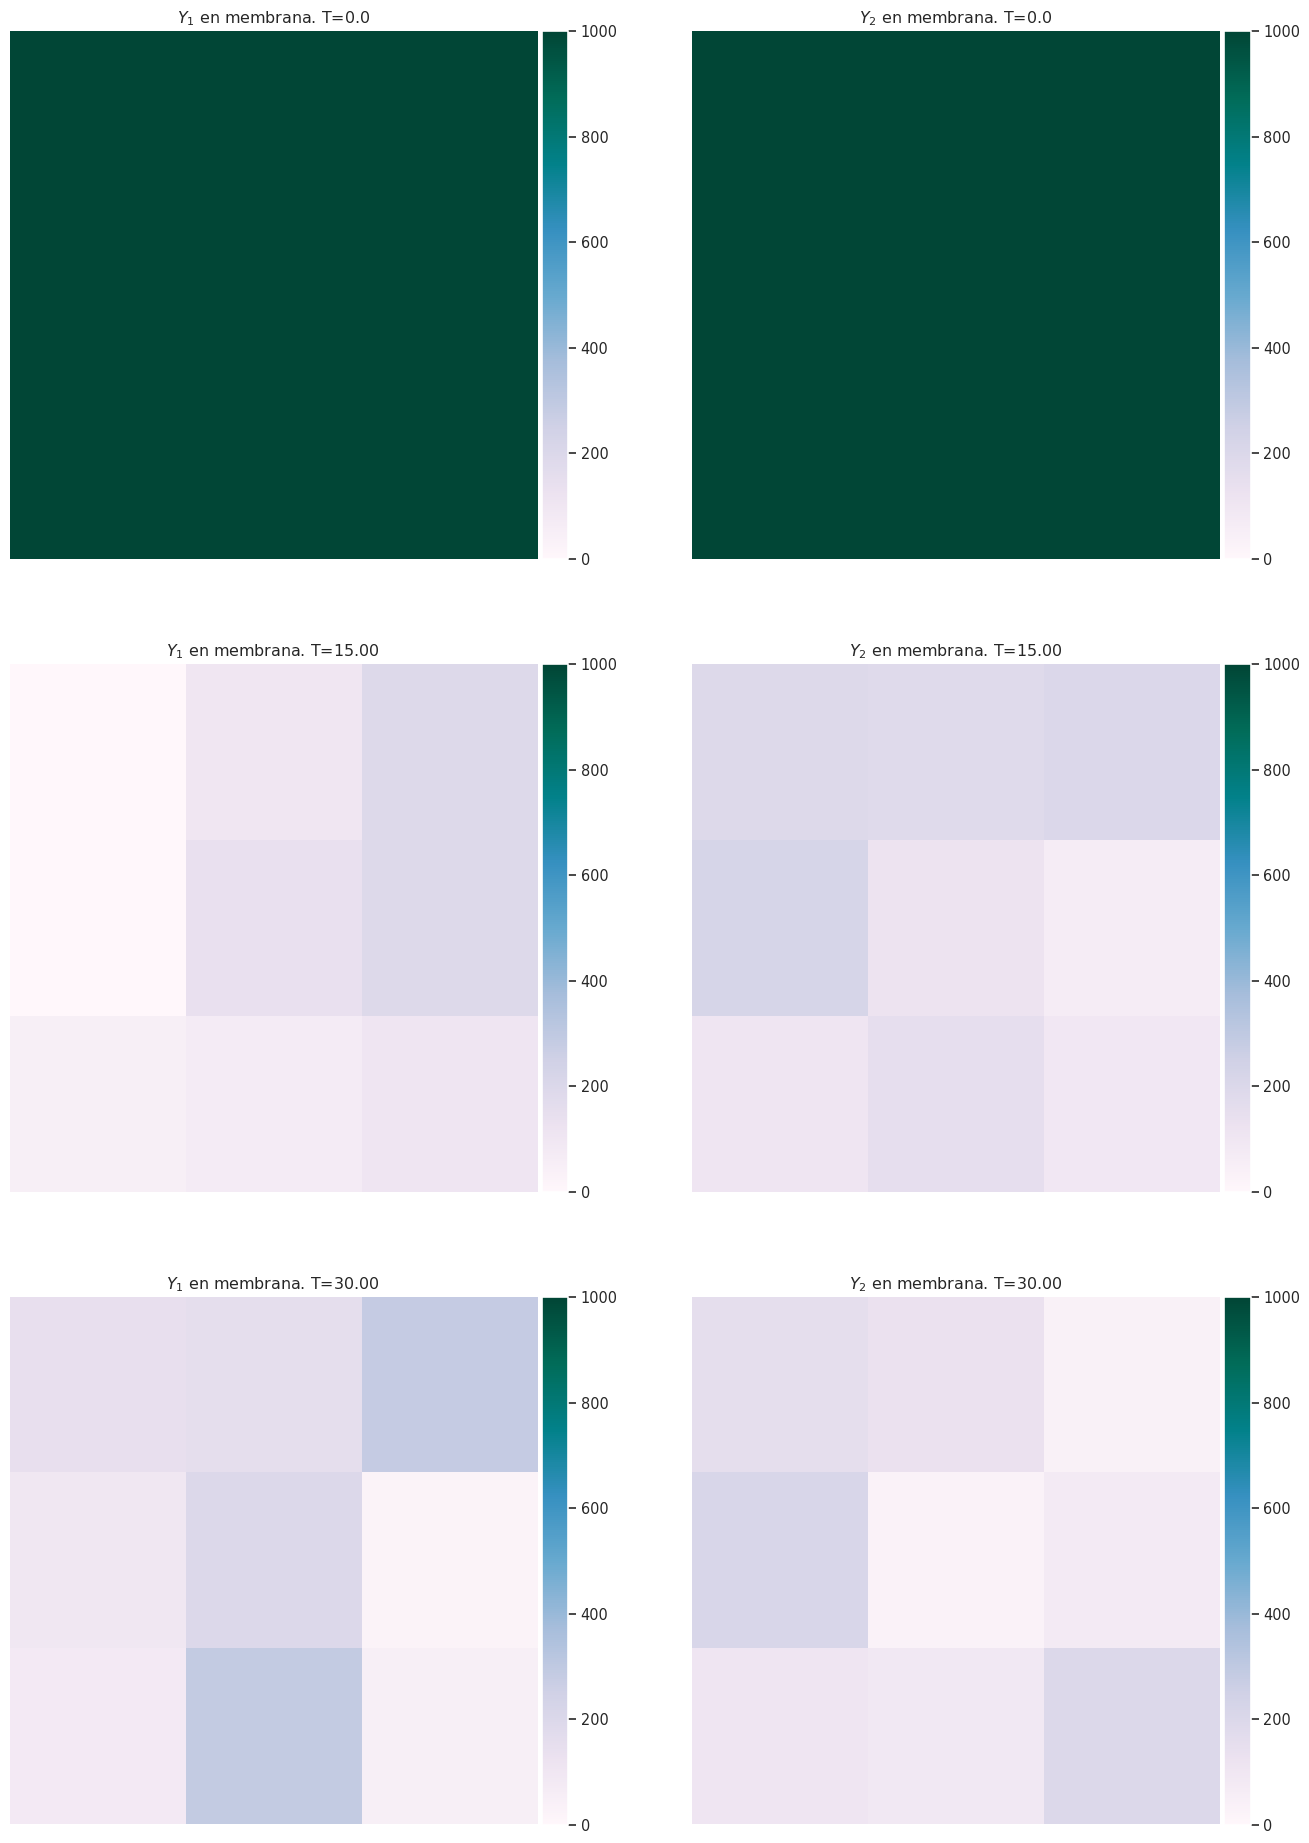

In [141]:
fig,ax = plt.subplots(3,2,dpi=95,figsize=(17,25))

im = ax[0,0].imshow(evolM[0][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0,0].set_title(r'$Y_1$ en membrana. T={}'.format(T[0]),fontdict={'fontsize':12,})
ax[0,0].set_axis_off()

im = ax[0,1].imshow(evolM[0][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0,1].set_title(r'$Y_2$ en membrana. T={}'.format(T[0]),fontdict={'fontsize':12,})
ax[0,1].set_axis_off()

# Second Row

im = ax[1,0].imshow(evolM[np.where(T==T[T<15.0][-1])[0][0]][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1,0].set_title(r'$Y_1$ en membrana. T={:.2f}'.format(T[np.where(T==T[T<15.0][-1])[0][0]]),fontdict={'fontsize':12,})
ax[1,0].set_axis_off()

im = ax[1,1].imshow(evolM[np.where(T==T[T<15.0][-1])[0][0]][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1,1].set_title(r'$Y_2$ en membrana. T={:.2f}'.format(T[np.where(T==T[T<15.0][-1])[0][0]]),fontdict={'fontsize':12,})
ax[1,1].set_axis_off()


# Third Row

im = ax[2,0].imshow(evolM[-1][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[2,0].set_title(r'$Y_1$ en membrana. T={:.2f}'.format(T[-1]),fontdict={'fontsize':12,})
ax[2,0].set_axis_off()

im = ax[2,1].imshow(evolM[-1][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[2,1].set_title(r'$Y_2$ en membrana. T={:.2f}'.format(T[-1]),fontdict={'fontsize':12,})
ax[2,1].set_axis_off()


plt.show()

In [77]:
#
# Esta animación no la pudo hacer mi computadora
# Se alcanzaron 908,047 reacciones
#
# fig, ax = plt.subplots(1,2,figsize=(17,8),dpi=93)
# img = []

# ax[0].set_axis_off()
# ax[1].set_axis_off()

# im1 = ax[0].imshow(evolM[0][0],cmap='PuBuGn',
#               vmin=0,
#               vmax=np.max(evolM[0][0]))
# im2 = ax[1].imshow(evolM[0][1],cmap='PuBuGn',
#               vmin=0,
#               vmax=np.max(evolM[0][1]))


# divider1 = make_axes_locatable(ax[0])
# cax1 = divider1.append_axes("right", size="5%", pad=0.05)
# cbar1 = plt.colorbar(im1, cax=cax)

# divider2 = make_axes_locatable(ax[1])
# cax2 = divider2.append_axes("right", size="5%", pad=0.05)
# cbar2 = plt.colorbar(im2, cax=cax)

# ax[0].set_title(r'Lotka Reaction membrane $Y_{1}$')
# ax[1].set_title(r'Lotka Reaction membrane $Y_{2}$')

# for t,m in zip(T[::100],evolM[::100]):
#     title_1 = ax[0].text(0.5,1.05,"T = {:.2f}".format(t), 
#                     size=plt.rcParams["axes.titlesize"],
#                     ha="center", transform=ax[0].transAxes, )
    
#     title_2 = ax[1].text(0.5,1.05,"T = {:.2f}".format(t), 
#                     size=plt.rcParams["axes.titlesize"],
#                     ha="center", transform=ax[1].transAxes, )
    
#     img.append([ax[0].imshow(m[0],
#                           cmap='PuBuGn',
#                           vmin=0,
#                           vmax=np.max(evolM[0][0]),),title_1,
#                ax[1].imshow(m[1],
#                           cmap='PuBuGn',
#                           vmin=0,
#                           vmax=np.max(evolM[0][1]),),title_2,])
    
# plt.close()

In [80]:
#anim = animation.ArtistAnimation(fig, img, interval=10, blit=True,repeat_delay=0)

In [87]:
# equivalent to rcParams['animation.html'] = 'html5'
#rc('animation', html='jshtml')
#HTML(anim.to_jshtml())

##  1.4 Introducción de difusión en Reacciones de Lotka 

Si introducimos la difusión a las reacciones de Lotka obtenemos lo siguiente:
$$
\begin{eqnarray}
&\bar{X} + Y_{1}& \xrightarrow{\;\; C_{1} \;\; } 2Y_{1} \\
&Y_{1} + Y_{2}& \xrightarrow{\;\; C_{2} \;\; } 2Y_{2} \\
&Y_{2}& \xrightarrow{\;\; C_{3} \;\; } Z \\
&Y_{1}(i)& \xrightarrow{\;\; C_{4} \;\; } Y_{1}(j) \\
&Y_{2}(i)& \xrightarrow{\;\; C_{5} \;\; } Y_{2}(j)
\end{eqnarray}
$$

Donde $\bar{X}$ denota una población molecular constante en el tiempo, $c_{4}$ y $c_{5}$ son nuestros coeficientes de difusión y $Y_{i}(j)$ denota a la población de la especie $Y_{i}$ en el nodo $j$.

Las nuevas ecuaciones de propensidad son las siguientes:
$$
\begin{eqnarray}
a_{1}(\mathbf{Y}) &=& c_1 [\bar{X}][Y_{1}] = k[Y_{1}]\\
a_{2}(\mathbf{Y}) &=& c_2 [Y_{2}][Y_{1}] \\
a_{3}(\mathbf{Y}) &=& c_3 [Y_{2}] \\
a_{4}(\mathbf{Y}) &=& c_4 [Y_{1}] \\
a_{5}(\mathbf{Y}) &=& c_5 [Y_{2}]
\end{eqnarray}
$$
Y los vectores de _cambio de estado_ son los siguientes:
$$
\begin{eqnarray}
\nu_{1} &=& [1,0] \\
\nu_{2} &=& [-1,-1] \\
\nu_{3} &=& [0,-1] \\
\nu_{4} &=& [-1,0] \\
\nu_{5} &=& [0,-1]
\end{eqnarray}
$$

Vamos a iniciar con ambos valores de difusión como $c_4 = c_5 = 0.4$

In [146]:
def R(Y,k=10,c2=0.01,c3=10,c4=0.4,c5=0.4):
    return np.asarray([k*Y[0],c2*Y[0]*Y[1], c3*Y[1],c4*Y[0],c5*Y[1]])

In [149]:
def select_patch(tensor,interest_func_selection,patch_idx,n):
    A = np.sum(tensor[interest_func_selection,:,:],axis=0).reshape(n)
    return random.choices(patch_idx, weights=map(truediv,A,[sum(A)]*n))[0]

In [168]:
def SSA(M,a,interest_func,v,t_max=1,seed=42):
    
    np.random.seed(seed=42)
    
    evolM = []
    evolM.append(M)
    
    T = []
    T.append(0)
    t0 = 0
    #Jj = []
    sp = M.shape[1] #define dimension
    n = sp**2 # Define flaten dimension
    patch_idx_2d = list(itertools.product(range(sp),range(sp))) #define all the combinations of matrix entries
    patch_idx = list(range(sp**2)) #The idx of patch_idx_2d combinations
    neighb_patch = list(filter(lambda x: abs(x[0])!=abs(x[1]),itertools.product(range(-1,2),range(-1,2)))) # The valid neighbors
    idx = list(range(len(v)))
    while t0<=t_max:
        
        #select population
        Mt = evolM[len(evolM)-1].copy()
        t0 = T[len(T)-1]
        m_sum = [np.sum(i) for i in Mt]
        
        #select reaction
        a_vector = a(m_sum)
        a_0 = np.sum(a_vector)
        j = random.choices(idx,weights=a_vector/a_0)[0]
       
        #selct patch
        J = select_patch(M,interest_func[j],patch_idx,n)
        if j<3:
            for p in range(Mt.shape[0]):
                Mt[p,patch_idx_2d[J][0],patch_idx_2d[J][1]] = a_positive(Mt[p,patch_idx_2d[J][0],patch_idx_2d[J][1]]+v[j][p])
        else:
            dummy = random.choices(neighb_patch,k=1)[0]
            for p in range(Mt.shape[0]):
                if a_positive(Mt[p,patch_idx_2d[J][0],patch_idx_2d[J][1]]+v[j][p])>0:
                    #print('{}->{},{},vector = {},{}'.format(patch_idx_2d[J],[(patch_idx_2d[J][0]+dummy[0])%sp ,(patch_idx_2d[J][1]+dummy[1])%sp],dummy,v[j],j))
                    Mt[p,patch_idx_2d[J][0],patch_idx_2d[J][1]] += v[j][p]
                    Mt[p,(patch_idx_2d[J][0]+dummy[0])%sp ,(patch_idx_2d[J][1]+dummy[1])%sp ] += -v[j][p]
        
        tau = random_exp_numpy(a_0)
        
        evolM.append(Mt)
        T.append(t0+tau)
        
    return evolM,T    

In [169]:
M = np.array([np.ones((3,3))*1000,np.ones((3,3))*1000])

In [170]:
interest_func = [[0],
                 [0,1],
                 [1],
                 [0],
                 [1]]

v = [[1,0],
    [-1,1],
    [0,-1],
    [-1,0],
    [0,-1]]

In [172]:
evolM, T = SSA(M,a=R,interest_func=interest_func,v=v,t_max=30)

In [173]:
Y1,Y2 = zip(*[(np.sum(m[0]),np.sum(m[1])) for m in evolM])

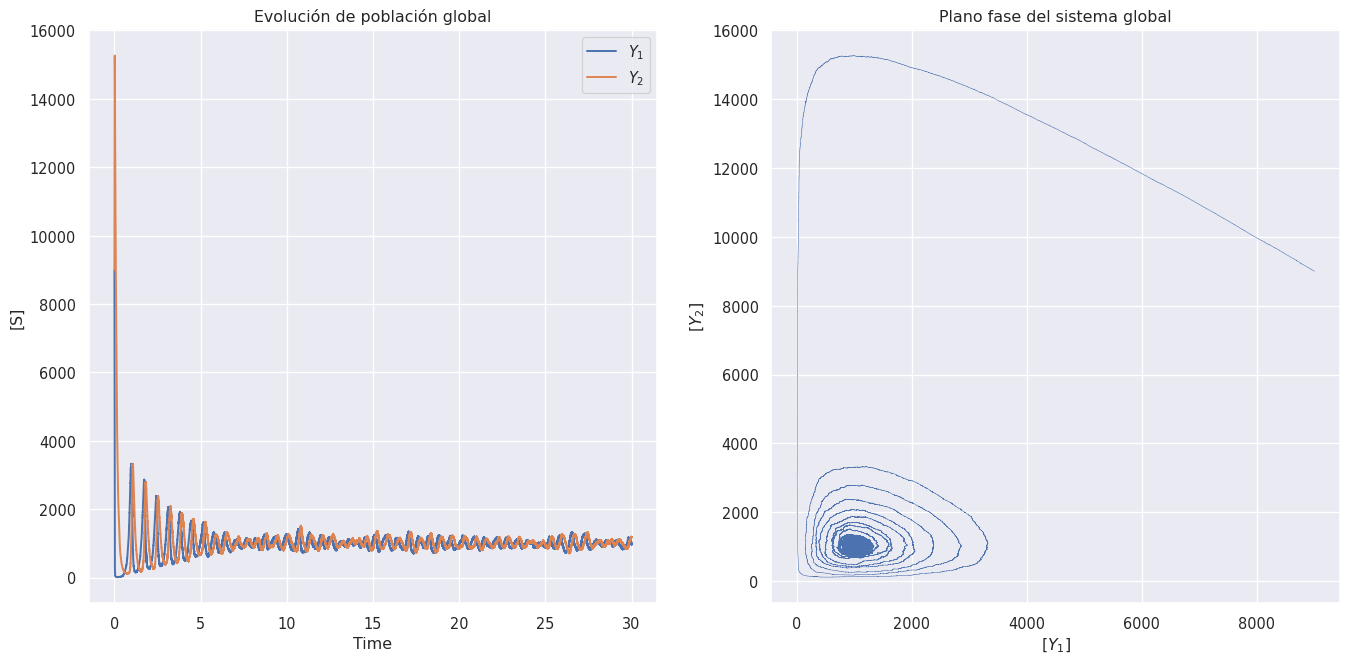

In [174]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,8))

ax[0].plot(T,Y1,label=r'$Y_{1}$')
ax[0].plot(T,Y2,label=r'$Y_{2}$')

ax[0].set_title('Evolución de población global')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('[S]')
ax[0].legend()

ax[1].plot(Y1,Y2,lw=0.4)
ax[1].set_title('Plano fase del sistema global')
ax[1].set_xlabel(r'[$Y_{1}$]')
ax[1].set_ylabel(r'[$Y_{2}$]')
#ax[1].legend()


plt.show()

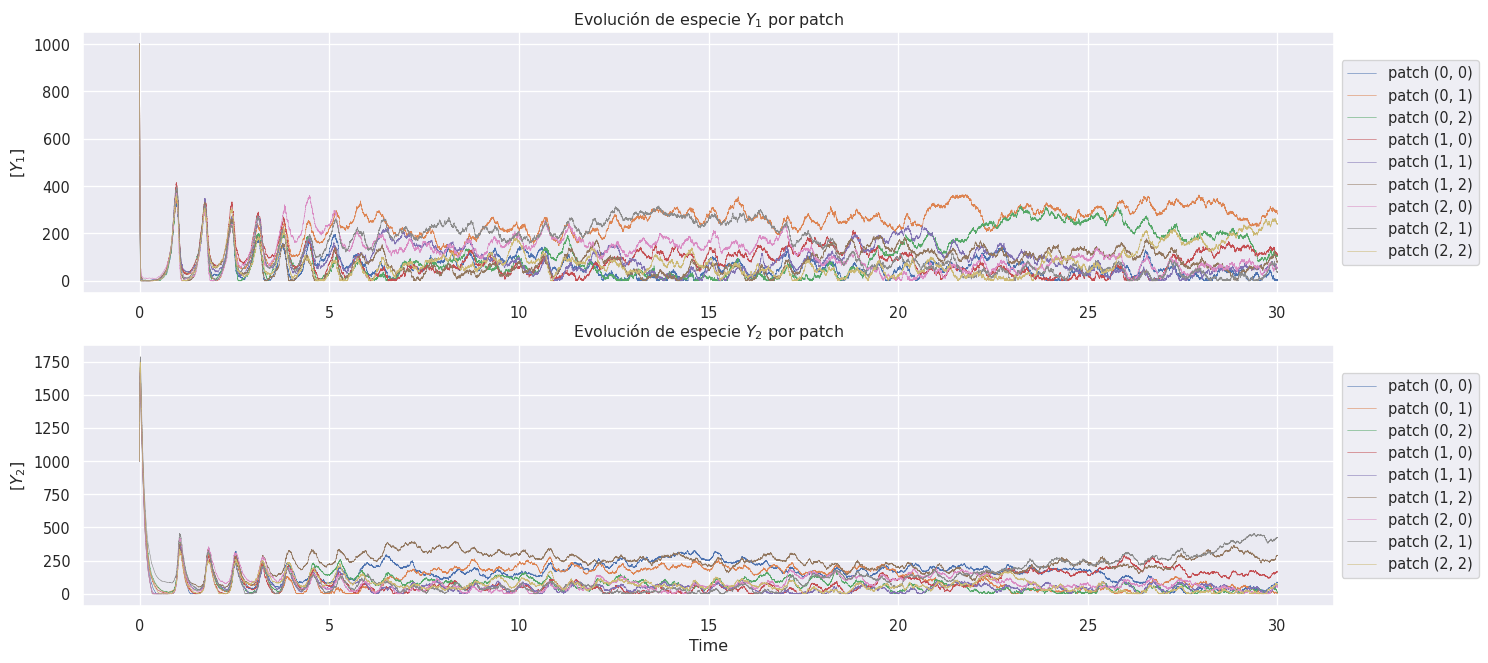

In [175]:
fig,ax = plt.subplots(2,1,dpi=95,figsize=(17,8))

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[0].plot(T,[m[0][patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch),lw=0.4)
    
ax[0].set_title('Evolución de especie $Y_{1}$ por patch')
#ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'[$Y_{1}$]')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for patch in patch_idx_2d:
    ax[1].plot(T,[m[1][patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch),lw=0.4)
ax[1].set_title('Evolución de especie $Y_{2}$ por patch')
ax[1].set_ylabel(r'[$Y_{2}$]')
ax[1].set_xlabel('Time')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

In [177]:
T = np.array(T)

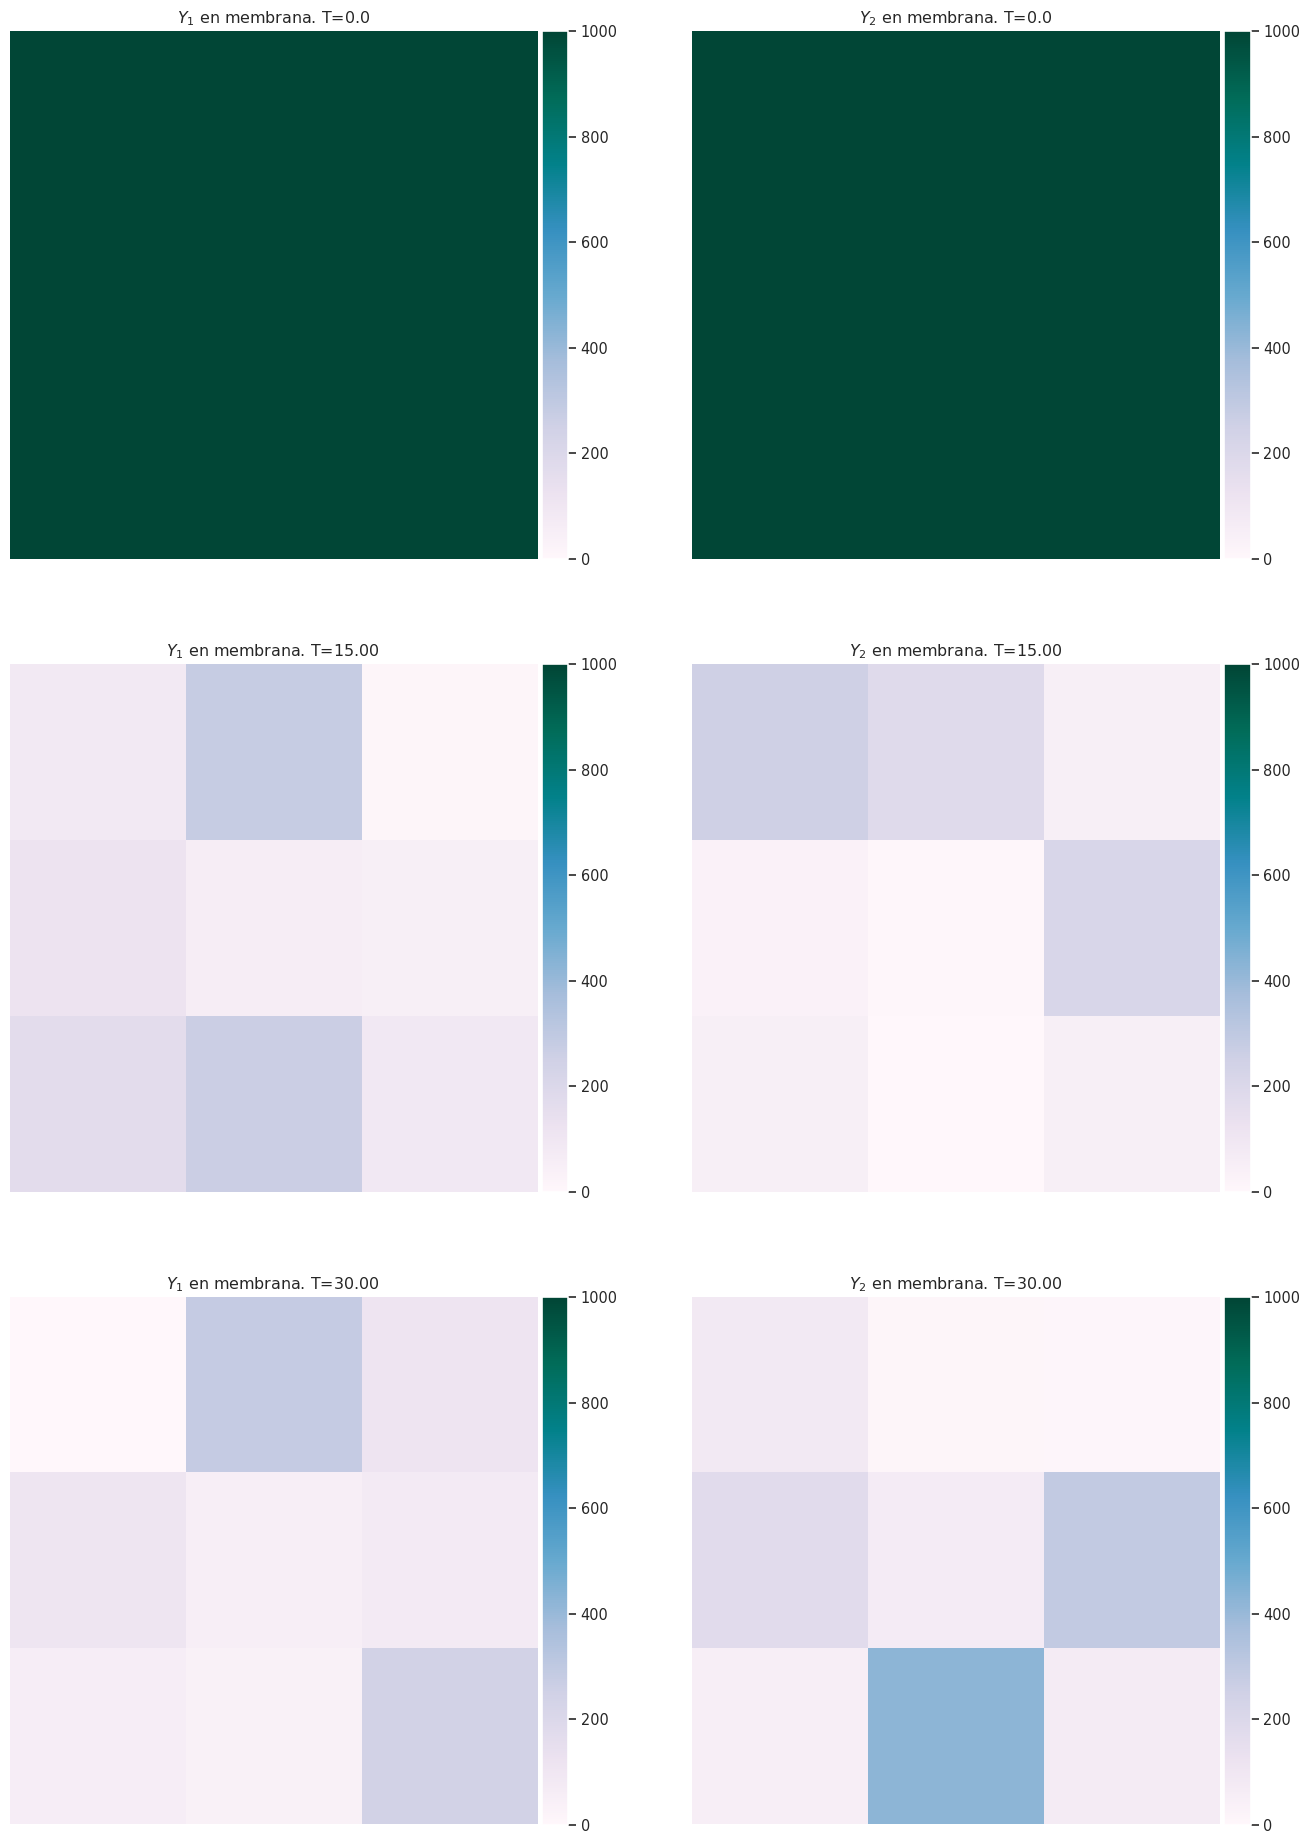

In [178]:
fig,ax = plt.subplots(3,2,dpi=95,figsize=(17,25))

im = ax[0,0].imshow(evolM[0][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0,0].set_title(r'$Y_1$ en membrana. T={}'.format(T[0]),fontdict={'fontsize':12,})
ax[0,0].set_axis_off()

im = ax[0,1].imshow(evolM[0][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0,1].set_title(r'$Y_2$ en membrana. T={}'.format(T[0]),fontdict={'fontsize':12,})
ax[0,1].set_axis_off()

# Second Row

im = ax[1,0].imshow(evolM[np.where(T==T[T<15.0][-1])[0][0]][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1,0].set_title(r'$Y_1$ en membrana. T={:.2f}'.format(T[np.where(T==T[T<15.0][-1])[0][0]]),fontdict={'fontsize':12,})
ax[1,0].set_axis_off()

im = ax[1,1].imshow(evolM[np.where(T==T[T<15.0][-1])[0][0]][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1,1].set_title(r'$Y_2$ en membrana. T={:.2f}'.format(T[np.where(T==T[T<15.0][-1])[0][0]]),fontdict={'fontsize':12,})
ax[1,1].set_axis_off()


# Third Row

im = ax[2,0].imshow(evolM[-1][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[2,0].set_title(r'$Y_1$ en membrana. T={:.2f}'.format(T[-1]),fontdict={'fontsize':12,})
ax[2,0].set_axis_off()

im = ax[2,1].imshow(evolM[-1][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[2,1].set_title(r'$Y_2$ en membrana. T={:.2f}'.format(T[-1]),fontdict={'fontsize':12,})
ax[2,1].set_axis_off()


plt.show()

Hasta ahora parece que no hay un efecto muy grande en incluir la difusión pero vamos a poner un valor exagerado para ver cómo influye este efecto, vamos a poner $c_{4}=c_{5}=50$

In [180]:
evolM, T = SSA(M,a=lambda x:R(x,c4=50,c5=50),interest_func=interest_func,v=v,t_max=30)

In [181]:
Y1,Y2 = zip(*[(np.sum(m[0]),np.sum(m[1])) for m in evolM])

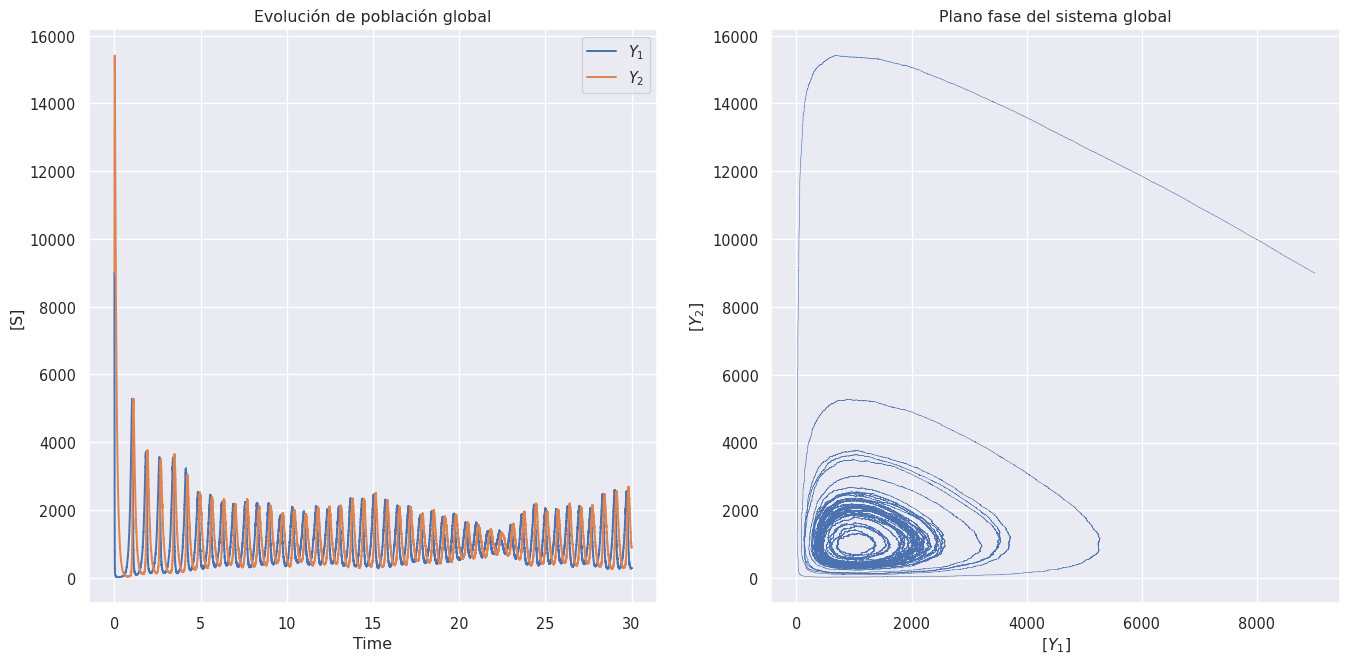

In [182]:
fig,ax = plt.subplots(1,2,dpi=95,figsize=(17,8))

ax[0].plot(T,Y1,label=r'$Y_{1}$')
ax[0].plot(T,Y2,label=r'$Y_{2}$')

ax[0].set_title('Evolución de población global')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('[S]')
ax[0].legend()

ax[1].plot(Y1,Y2,lw=0.4)
ax[1].set_title('Plano fase del sistema global')
ax[1].set_xlabel(r'[$Y_{1}$]')
ax[1].set_ylabel(r'[$Y_{2}$]')
#ax[1].legend()


plt.show()

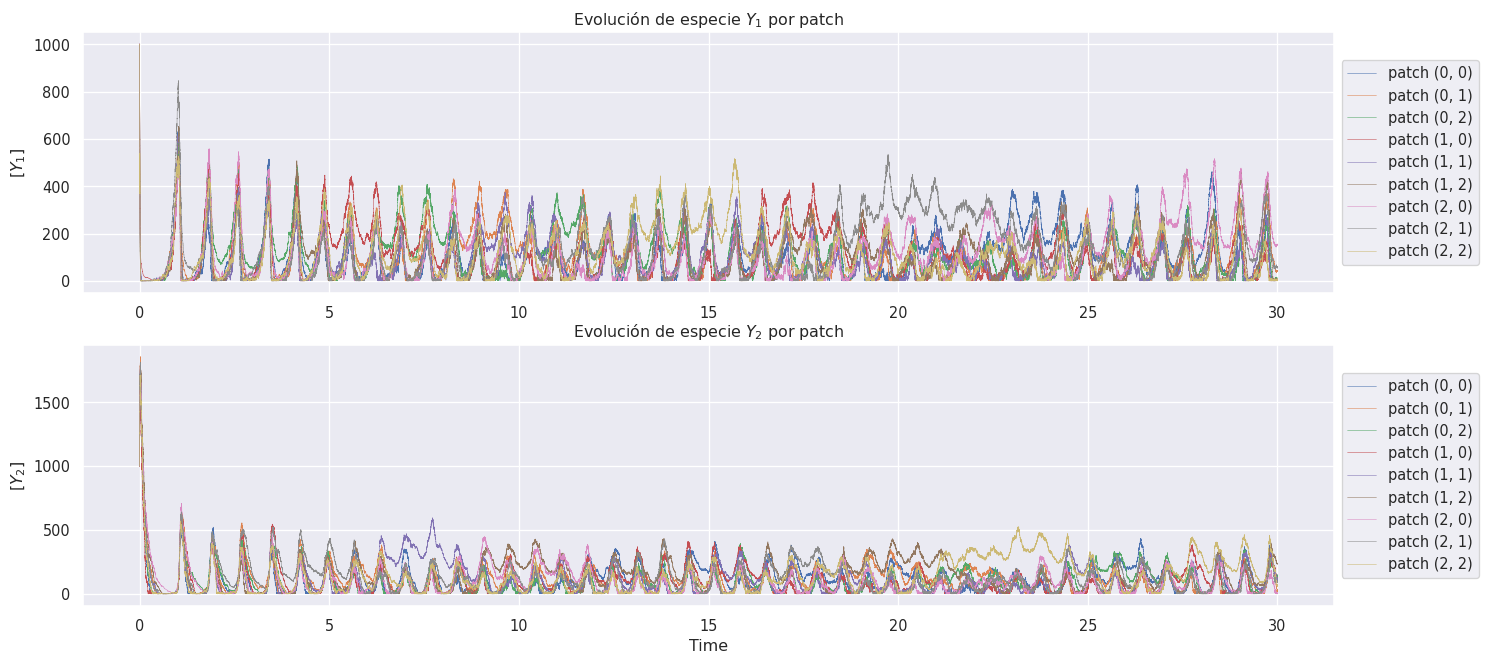

In [183]:
fig,ax = plt.subplots(2,1,dpi=95,figsize=(17,8))

patch_idx_2d = list(itertools.product(range(3),range(3)))
for patch in patch_idx_2d:
    ax[0].plot(T,[m[0][patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch),lw=0.4)
    
ax[0].set_title('Evolución de especie $Y_{1}$ por patch')
#ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'[$Y_{1}$]')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

for patch in patch_idx_2d:
    ax[1].plot(T,[m[1][patch[0],patch[1]] for m in evolM], label='patch {}'.format(patch),lw=0.4)
ax[1].set_title('Evolución de especie $Y_{2}$ por patch')
ax[1].set_ylabel(r'[$Y_{2}$]')
ax[1].set_xlabel('Time')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

In [184]:
T = np.array(T)

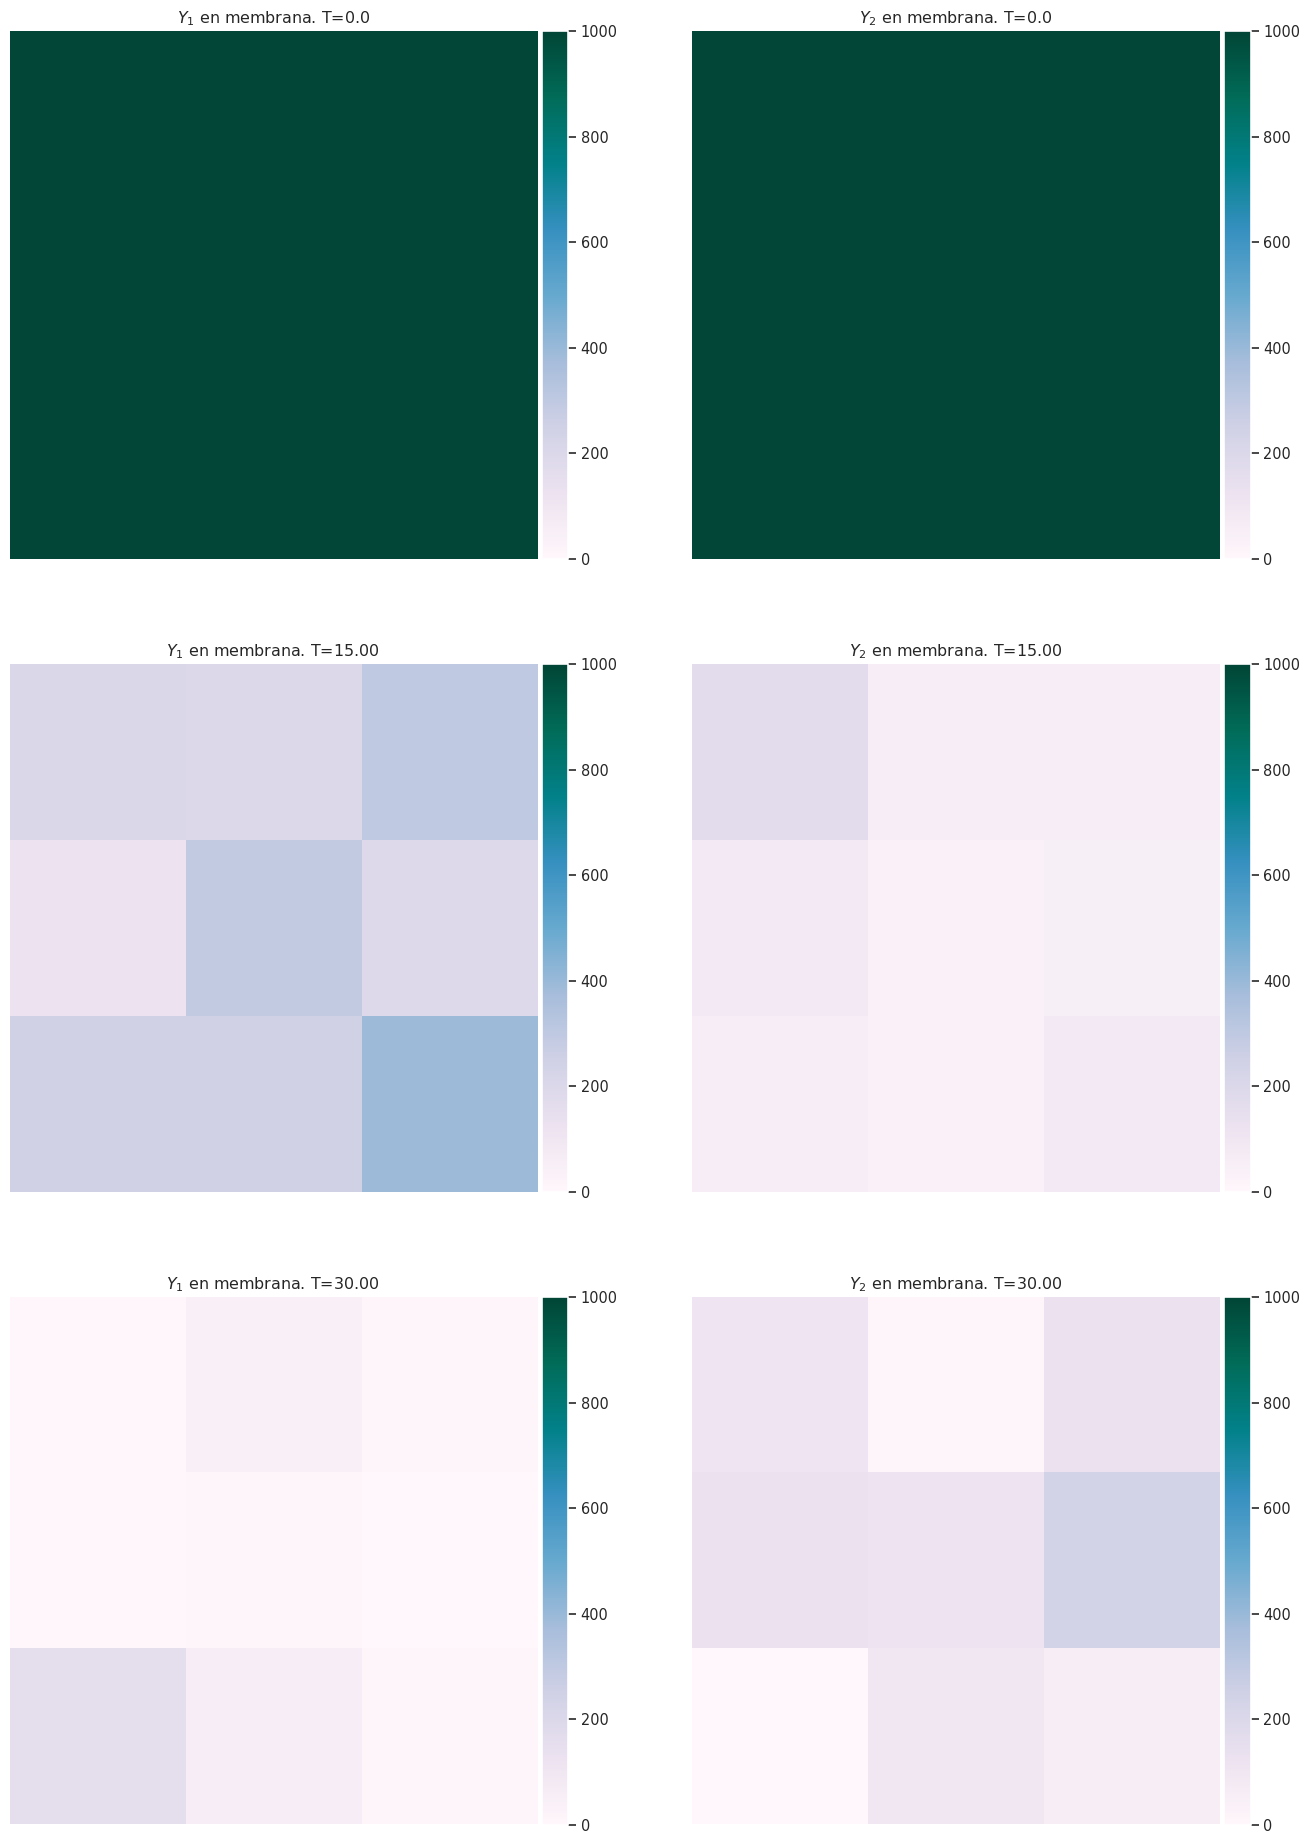

In [185]:
fig,ax = plt.subplots(3,2,dpi=95,figsize=(17,25))

im = ax[0,0].imshow(evolM[0][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0,0].set_title(r'$Y_1$ en membrana. T={}'.format(T[0]),fontdict={'fontsize':12,})
ax[0,0].set_axis_off()

im = ax[0,1].imshow(evolM[0][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[0,1].set_title(r'$Y_2$ en membrana. T={}'.format(T[0]),fontdict={'fontsize':12,})
ax[0,1].set_axis_off()

# Second Row

im = ax[1,0].imshow(evolM[np.where(T==T[T<15.0][-1])[0][0]][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1,0].set_title(r'$Y_1$ en membrana. T={:.2f}'.format(T[np.where(T==T[T<15.0][-1])[0][0]]),fontdict={'fontsize':12,})
ax[1,0].set_axis_off()

im = ax[1,1].imshow(evolM[np.where(T==T[T<15.0][-1])[0][0]][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[1,1].set_title(r'$Y_2$ en membrana. T={:.2f}'.format(T[np.where(T==T[T<15.0][-1])[0][0]]),fontdict={'fontsize':12,})
ax[1,1].set_axis_off()


# Third Row

im = ax[2,0].imshow(evolM[-1][0],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][0]))

divider = make_axes_locatable(ax[2,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[2,0].set_title(r'$Y_1$ en membrana. T={:.2f}'.format(T[-1]),fontdict={'fontsize':12,})
ax[2,0].set_axis_off()

im = ax[2,1].imshow(evolM[-1][1],
               cmap='PuBuGn',
              vmin=0,
              vmax=np.max(evolM[0][1]))

divider = make_axes_locatable(ax[2,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)

ax[2,1].set_title(r'$Y_2$ en membrana. T={:.2f}'.format(T[-1]),fontdict={'fontsize':12,})
ax[2,1].set_axis_off()


plt.show()

El introducir un efecto de difusión tan grande lo que nos dejó ver es un acoplamiento más fuerte: las oscilaciones se hacen más definidas y de mayor amplitud. Solamente como dato informativo se realizaron $3,990,274$ reacciones en este último caso.

Para finalizar este experimento vamos a tomar una membrana más grande, en este caso de $10\times 10$

In [188]:
M = np.array([np.ones((10,10))*1000,np.ones((10,10))*1000])

Vamos a continuar con los mismos valores de difusión. 

In [ ]:
evolM, T = SSA(M,a=lambda x:R(x,c4=50,c5=50),interest_func=interest_func,v=v,t_max=30)